# Project : Registration of anatomical and functional pelvis images

Charline Curaut 3810013

### Useful libraires

In [23]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import imutils

### Manipulation of data to get familiarized

In [6]:
minor_b0 = nib.load('EXAMPLE-b0-T2/minor/1-2-14_off_210111_b0DWI.nii').get_fdata()
print(minor_b0.shape)

minor_T2 = nib.load('EXAMPLE-b0-T2/minor/1-2-14_off_210111_coroT2Cube.nii').get_fdata()
print(minor_T2.shape)

minor_T2_mask = nib.load('EXAMPLE-b0-T2/minor/1-2-14_off_210111_T2Mask.nii').get_fdata()
print(minor_T2_mask.shape)

(256, 256, 75)
(400, 179, 400)
(400, 179, 400)


#### Visualization of a slice for each data (it doesn't necessarily correspond) :

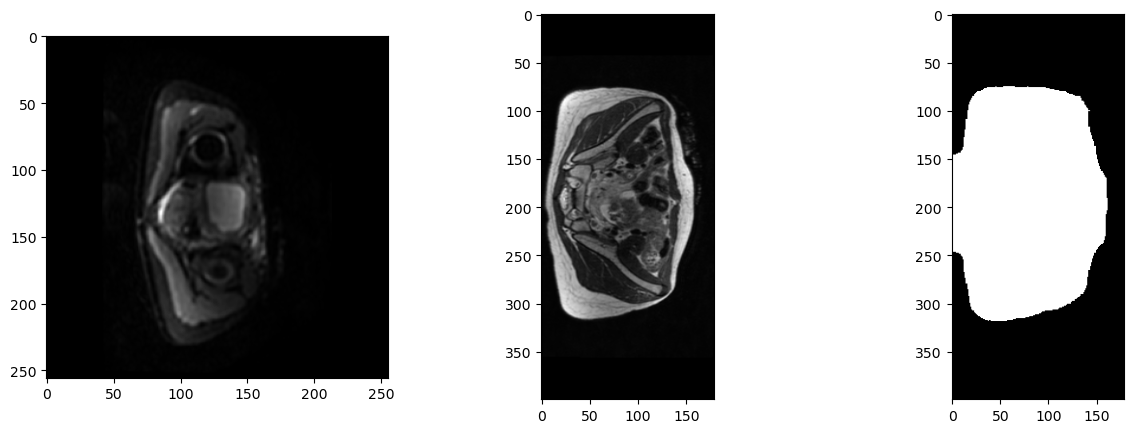

In [41]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
#test_b0 = imutils.rotate(minor_b0[:,:,30], angle=90)
test_b0 = minor_b0[:,:,33]
plt.imshow(test_b0, cmap="gray")

plt.subplot(1,3,2)
#test_T2 = imutils.rotate(minor_T2[:,:,200].T, angle=180)
test_T2 = minor_T2[:,:,200]
plt.imshow(test_T2, cmap="gray")

plt.subplot(1,3,3)
#test_T2_mask = imutils.rotate(minor_T2_mask[:,:,200].T, angle=180)
test_T2_mask = minor_T2_mask[:,:,200]
plt.imshow(test_T2_mask, cmap="gray")

plt.show()

In [34]:
test_b0 = imutils.rotate(minor_b0[:,:,30].T, angle=180)
test_b0 = imutils.rotate(test_b0, angle=180).T
verif = np.where(test_b0 == minor_b0[:,:,30],1,0)
print(verif)
print(verif.sum())

[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
65025


$65\;025 = 256 * 256 - 256 - 255$

It seems like the double action of transversing and rotation of the image by 180 degrees only changes two edges of the image (up and left). These pixels are black anyways so it won't change the result if we manipulate the images like this for the rest of the experiment (if we do that action once and not twice, the images have the same orientation than in 3D Slicer). It less confusing but not necessary. 

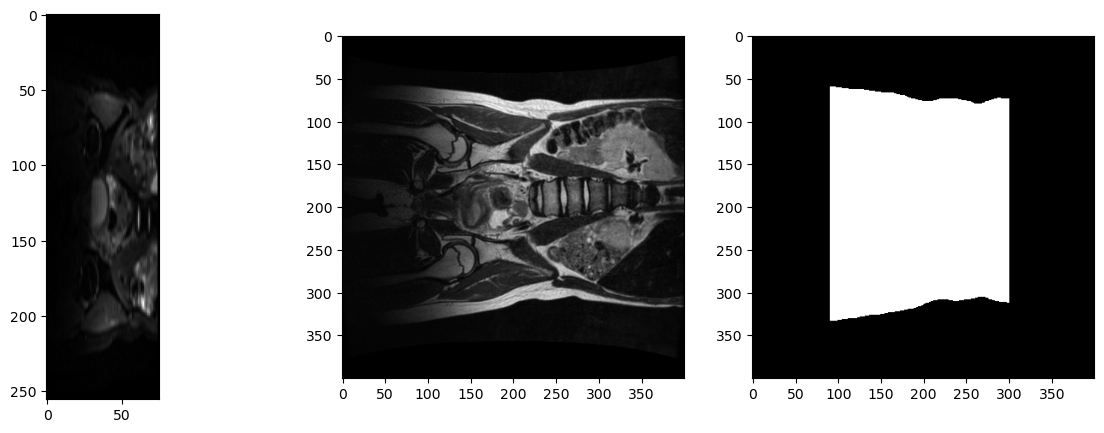

In [42]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
test_b0 = minor_b0[:,127,:]
plt.imshow(test_b0, cmap="gray")

plt.subplot(1,3,2)
test_T2 = minor_T2[:,80,:]
plt.imshow(test_T2, cmap="gray")

plt.subplot(1,3,3)
test_T2_mask = minor_T2_mask[:,80,:]
plt.imshow(test_T2_mask, cmap="gray")

plt.show()